In [1]:
# Tez is currently not available on kaggle but you can install it using pip 
# or just add tez-lib dataset to the python path.
# If internet is enabled (and allowed), you can just install using pip
!pip install tez

In [2]:
# If internet is disabled, you can add it to path after 
# including https://www.kaggle.com/abhishek/tez-lib
# dataset to your kernel
#
# Add the following lines of the code to top of your kernel, 
# if you cannot install using pip
#
# tez_path = '../input/tez-lib/'
# import sys
# sys.path.append(tez_path)

In [3]:
# Everything becomes easy and intuitive from here. 
# Also, Tez keeps your code clean and readable!
# Let's import a few things.

import os

import albumentations
import matplotlib.pyplot as plt
import pandas as pd

import tez
from tez.datasets import ImageDataset
from tez.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.nn import functional as F

import torchvision

from sklearn import metrics, model_selection, preprocessing

%matplotlib inline

In [4]:
# Let's read the CSV file
dfx = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')

# and split it into training and validation sets
df_train, df_valid = model_selection.train_test_split(
    dfx, 
    test_size=0.1, 
    random_state=42,
    stratify=dfx.label.values
)

# reset index on both dataframes
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

# where are the train/valid images located?
image_path = "../input/cassava-leaf-disease-classification/train_images/"

# create a list of image paths for training
train_image_paths = [os.path.join(image_path, x) for x in df_train.image_id.values]

# create a list of image paths for validation
valid_image_paths = [os.path.join(image_path, x) for x in df_valid.image_id.values]

# targets for training
train_targets = df_train.label.values

# targets for validation
valid_targets = df_valid.label.values

In [5]:
# Let's create training and validation datasets
# Tez provides simple dataset class that you can use directly

# we create the train_dataset
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    resize=(256, 256),
    augmentations=None,
)

# and the validation dataset
valid_dataset = ImageDataset(
    image_paths=valid_image_paths,
    targets=valid_targets,
    resize=(256, 256),
    augmentations=None,
)

# note that we have resized the images to 256x256
# and we are not using any augmentations
# we will come back to that later

In [6]:
# how does the output of dataset class look like?
# lets look at an item
train_dataset[0]

{'image': tensor([[[ 46.,  42.,  43.,  ...,  43.,  49.,  64.],
          [ 44.,  42.,  47.,  ...,  32.,  33.,  43.],
          [ 35.,  36.,  48.,  ...,  23.,  24.,  26.],
          ...,
          [ 80.,  72.,  84.,  ...,  69.,  71.,  63.],
          [ 72.,  67.,  73.,  ...,  82.,  84.,  78.],
          [ 64.,  61.,  62.,  ...,  95.,  96.,  92.]],
 
         [[109., 112., 123.,  ...,  94.,  92., 100.],
          [111., 114., 125.,  ...,  87.,  81.,  84.],
          [108., 110., 124.,  ...,  84.,  79.,  75.],
          ...,
          [138., 131., 144.,  ..., 130., 131., 125.],
          [134., 131., 137.,  ..., 133., 133., 129.],
          [131., 128., 129.,  ..., 134., 134., 131.]],
 
         [[ 30.,  21.,  16.,  ...,   3.,   2.,   7.],
          [ 32.,  28.,  25.,  ...,   1.,   0.,   2.],
          [ 27.,  29.,  32.,  ...,   1.,   1.,   2.],
          ...,
          [ 59.,  53.,  58.,  ...,   1.,   4.,   2.],
          [ 52.,  52.,  55.,  ...,   1.,   4.,   3.],
          [ 47.,  49.,

In [7]:
# thus, we have image and targets
# super-easy!

# Let's see some images!

def plot_image(img_dict):
    image_tensor = img_dict["image"]
    target = img_dict["targets"]
    print(target)
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0) / 255
    plt.imshow(image)

tensor(1)


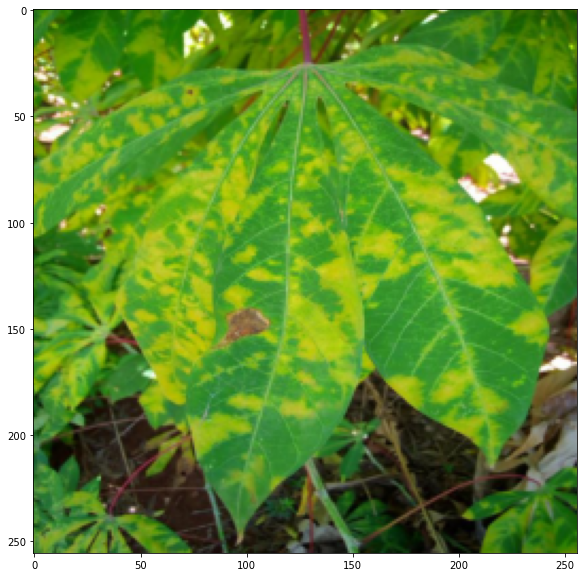

In [8]:
plot_image(train_dataset[0])

In [9]:
# Now, lets add some augmentations using one of the best
# augmentations library: albumentations
# Tez supports albumentations exclusively

train_aug = albumentations.Compose(
    [
        albumentations.RandomResizedCrop(256, 256),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5),
        # albumentations.Normalize(
        #    mean=[0.485, 0.456, 0.406], 
        #    std=[0.229, 0.224, 0.225], 
        #    max_pixel_value=255.0, 
        #    p=1.0
        #)
    ]
)


# now, we set resize to None as we are doing 
# resizing via augmentations
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    resize=None,
    augmentations=train_aug,
)

tensor(1)


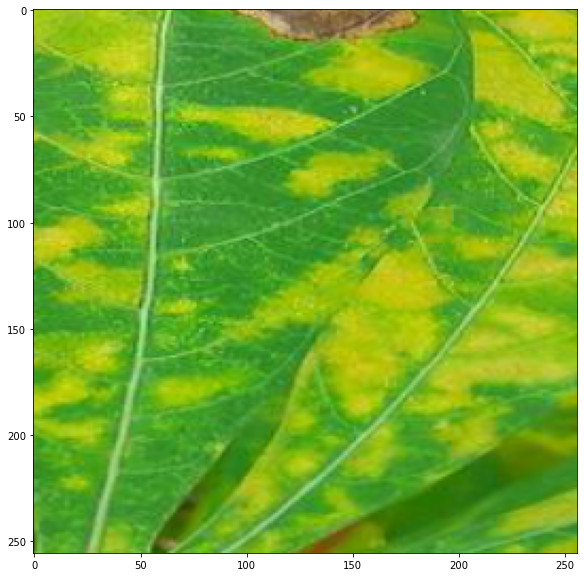

In [10]:
plot_image(train_dataset[0])

In [11]:
# Let's define a model now
# We inherit from tez.Model instead of nn.Module
# we have monitor_metrics if we want to monitor any metrics
# except the loss
# and we return 3 values in forward function.

class LeafModel(tez.Model):
    def __init__(self, num_classes):
        super().__init__()

        self.convnet = torchvision.models.resnet18(pretrained=True)
        self.convnet.fc = nn.Linear(512, num_classes)
        self.step_scheduler_after = "epoch"
        
    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, outputs)
        return {"accuracy": accuracy}
    
    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return opt
    
    def fetch_scheduler(self):
        sch = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=0.7)
        return sch

    def forward(self, image, targets=None):
        batch_size, _, _, _ = image.shape

        outputs = self.convnet(image)
        
        if targets is not None:
            loss = nn.CrossEntropyLoss()(outputs, targets)
            metrics = self.monitor_metrics(outputs, targets)
            return outputs, loss, metrics
        return outputs, None, None

In [12]:
model = LeafModel(num_classes=5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [13]:
image = train_dataset[0]["image"].unsqueeze(0)
target = train_dataset[0]["targets"].unsqueeze(0)


model(image, target)

(tensor([[-0.0691,  0.2851,  0.6362, -0.8557, -0.4973]],
        grad_fn=<AddmmBackward>),
 tensor(1.3608, grad_fn=<NllLossBackward>),
 {'accuracy': 0.0})

In [14]:
train_aug = albumentations.Compose([
            albumentations.RandomResizedCrop(256, 256),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            )], p=1.)
      
valid_aug = albumentations.Compose([
            albumentations.CenterCrop(256, 256, p=1.),
            albumentations.Resize(256, 256),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            )], p=1.)

train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    resize=None,
    augmentations=train_aug,
)

valid_dataset = ImageDataset(
    image_paths=valid_image_paths,
    targets=valid_targets,
    resize=None,
    augmentations=valid_aug,
)

In [15]:
es = EarlyStopping(
    monitor="valid_accuracy", model_path="model.bin", patience=2, mode="max"
)
model.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    train_bs=32,
    valid_bs=64,
    device="cuda",
    epochs=5,
    callbacks=[es],
    fp16=True,
)


Validation score improved (-inf --> 0.7265625). Saving model!



Validation score improved (0.7265625 --> 0.7553834033613446). Saving model!



Validation score improved (0.7553834033613446 --> 0.7710084033613446). Saving model!



EarlyStopping counter: 1 out of 2



EarlyStopping counter: 2 out of 2


In [16]:
test_dfx = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
image_path = "../input/cassava-leaf-disease-classification/test_images/"
test_image_paths = [os.path.join(image_path, x) for x in test_dfx.image_id.values]
# fake targets
test_targets = test_dfx.label.values


test_aug = albumentations.Compose([
            albumentations.CenterCrop(256, 256, p=1.),
            albumentations.Resize(256, 256),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            )], p=1.)

test_dataset = ImageDataset(
    image_paths=test_image_paths,
    targets=test_targets,
    resize=None,
    augmentations=test_aug,
)

In [17]:
preds = model.predict(test_dataset, batch_size=32, n_jobs=-1, device="cuda")
final_preds = None
for p in preds:
    if final_preds is None:
        final_preds = p
    else:
        final_preds = np.vstack((final_preds, p))
final_preds = final_preds.argmax(axis=1)
test_dfx.label = final_preds
test_dfx.to_csv("submission.csv", index=False)